# Проект №7 - Обучение с учителем

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Инструкция
1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
4. Проведите финальное тестирование.

### Признаки
* RowNumber — индекс строки в данных // ___количественный признак___
* CustomerId — уникальный идентификатор клиента // ___количественный признак___
* Surname — фамилия // ___категориальный признак___
* CreditScore — кредитный рейтинг // ___количественный признак___
* Geography — страна проживания // ___категориальный признак___
* Gender — пол // ___категориальный признак___
* Age — возраст // ___количественный признак___
* Tenure — количество недвижимости у клиента // ___количественный признак___
* Balance — баланс на счёте // *___количественный признак___
* NumOfProducts — количество продуктов банка, используемых клиентом // ___количественный признак___
* HasCrCard — наличие кредитной карты // ___количественный признак___
* IsActiveMember — активность клиента // ___количественный признак___
* EstimatedSalary — предполагаемая зарплата // ___количественный признак___


---

### Целевой признак
* ___Exited — факт ухода клиента___ // категориальный(бинарный) признак___

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
import itertools
import operator
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

Сделаем сразу замену типа у признака Exited на uint8, т.к. данный тип является стандартным для цифровых булевых значений в pandas.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data['Exited'] = data['Exited'].astype('uint8')
print(data.shape)
print()
print(data.info())
print()
data.head()

(10000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null uint8
dtypes: float64(3), int64(7), object(3), uint8(1)
memory usage: 1.0+ MB
None



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Сделаем замену наименований на нижний регистр с раздением нижний чертой, для корректной работы с признаками

In [3]:
new_columns = []
for item in list(data.columns):
    item = item.lower()
    new_columns.append(item)

#', '.join(new_columns)
new_columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',\
               'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']
data.columns = new_columns
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверка на дубли, чтобы не обучить на некорректных данных

In [4]:
data.duplicated().sum()

0

Дубликатов нет, проверим на пропуски

In [5]:
def search_nan(data, parametr=''):
    if parametr == '':
        series_null_list =[]
        series_null = data.isnull().sum().sort_values(ascending=False)
        for i in series_null.index:
            if series_null[i] > 0:
                print('В столбце -', i, '- пропущено:', series_null[i], ';')
                series_null_list.append(i)
        print()
    elif parametr != '':
        if data[parametr].isnull().sum() > 0:
            print('В столбце -', parametr, '- пропущено:', data[parametr].isnull().sum(), ';')
        else:
            print('нет пропусков')
    #return series_null_list
    print()
    

            
def search_none(data):
    problem =[]
    for column in data.columns:
        if data.loc[data[column] == 'None'][column].count() > 0:
            print('None обнаружен в столбце - ', column, '- в количестве', data.loc[data[column] == 'None'][column].count())
            problem.append(column)
    if len(problem) == 0:
        print('None пропусков нет в таблице')

    
search_none(data)
search_nan(data)

None пропусков нет в таблице
В столбце - tenure - пропущено: 909 ;




Сделаем замену на 0, в вывод дам более поднобный анализ

In [6]:
data['tenure'].fillna('0', inplace=True)
data['tenure'] = data['tenure'].astype('int64')
search_nan(data)

### Предварительный вывод:
Сделана предварительная замена значений признака "tenure" (количество недвижимости у клиента), на предварительном этапе заполднил нулевыми значениями, т.к. медиана и среднеее могут исказить картину. С точки зрения банка лучше иметь информацию, что у клиента нет недвижимости, чем она есть, т.к. владение недвижимым имуществом повышает кредитный рейтинг клиента, влияет на надежность. Таким образом, чтобы не возникало никаких иллюзий лучше обнулить, риски нужно минимизировать. Так как реальные убытки это не потенциальные и ощущаются.

Проблем в данных не обнаружено: дублей и None - нет, а пропуски устранены путем заполнения нулевыми значениями и только в одном признаке.

Имеется 3 категориальных признака: Surname(не нужен, мы не ищем зависимоти от фамилии), Gender, Geography и один бинарный: Exited. Для дальнешего обучения нужно удалить: признак Surname, т.к. он не несет никого влияния, идентификатор клиента - customer_id и row_number - индентификатор строки. Признаки: gender, geography - нужно преобразовать в бинарные методологией OHE (one-hot encoding). Как один из вариантов, можно проверить методологию OrdinalEncoding, но в данном проекте воспользуемся только OHE. 

Следующим шагом будет разделение выборок и приведение количественных признаков к единому масштабу, чтобы исключить разновесовое влияние.


### Удаление признака Surname, идентификатора строки, идентификатора клиента

In [7]:
data = data.drop(['surname', 'row_number', 'customer_id'], axis=1)

In [8]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Применение демми-признаков (ohe)

In [9]:
data_ohe = pd.get_dummies(data, drop_first = True)
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Создадим выборки и приведём объекты выборок к единому масштабу

In [10]:
features = data_ohe.drop('exited', axis=1)
target = data_ohe['exited']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=.25, random_state=12345)
print('Проверка размера выборок:')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

column_for_scaled = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

X_train_for_scaled = X_train.loc[:,column_for_scaled]
X_test_for_scaled = X_test.loc[:,column_for_scaled]

scaler = StandardScaler()

scaler.fit(X_train_for_scaled)
scaler_train_data = pd.DataFrame(scaler.transform(X_train_for_scaled), columns=column_for_scaled)
scaler_test_data = pd.DataFrame(scaler.transform(X_test_for_scaled), columns=column_for_scaled)

#X_train_sk = pd.DataFrame(scaler.transform(data_ohe), columns=column_for_scaled)
scaler_train_data.head(2)

Проверка размера выборок:
X_train (7500, 11)
X_test (2500, 11)
Y_train (7500,)
Y_test (2500,)


,credit_score,age,tenure,balance,estimated_salary
0,0.442805,-0.841274,1.426885,-1.224577,-1.269750
1,-0.310897,-0.270730,0.784858,0.641783,0.960396


In [11]:
diff_column = set(data_ohe.columns)-set(column_for_scaled)
diff_column

{'exited',
 'gender_Male',
 'geography_Germany',
 'geography_Spain',
 'has_cr_card',
 'is_active_member',
 'num_of_products'}

In [12]:
diff_column = ['gender_Male', 'geography_Germany', 'geography_Spain', 'has_cr_card', 'is_active_member', 'num_of_products']
temp_train = X_train.loc[:,diff_column].reset_index(drop=True);
temp_test = X_test.loc[:,diff_column].reset_index(drop=True);

In [13]:
X_train_scaled = pd.concat([scaler_train_data, temp_train], axis=1)
X_test_scaled = pd.concat([scaler_test_data, temp_test], axis=1)
X_train_scaled.head(2)

,credit_score,age,tenure,balance,estimated_salary,gender_Male,geography_Germany,geography_Spain,has_cr_card,is_active_member,num_of_products
0,0.442805,-0.841274,1.426885,-1.224577,-1.269750,0,0,0,1,1,2
1,-0.310897,-0.270730,0.784858,0.641783,0.960396,0,0,1,1,1,1


In [14]:
#scaler = StandardScaler()
#num_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
#X_train[num_features] = scaler.fit_transform(X_train[num_features])
#X_test[num_features] = scaler.transform(X_test[num_features])

### Проанализируем баланс классов

In [15]:
print('Дисбаланс классов на тренировочной выборке =', round(Y_train[Y_train==0].count()/Y_train[Y_train==1].count(),2))
print('Дисбаланс классов на тренировочной выборке =', round(Y_test[Y_test==0].count()/Y_test[Y_test==1].count(),2))
print('Дисбаланс классов усредненный, округленный до целой части =',\
      round(target[target==0].count()/target[target==1].count(),0))

Дисбаланс классов на тренировочной выборке = 3.99
Дисбаланс классов на тренировочной выборке = 3.67
Дисбаланс классов усредненный, округленный до целой части = 4.0


### Вывод:
1/5 часть клиентов ушла, в представленном датасете дисбаланс между калссами в 4 раза.

# 2. Исследование задачи

In [16]:
X_train_scaled.head()

,credit_score,age,tenure,balance,estimated_salary,gender_Male,geography_Germany,geography_Spain,has_cr_card,is_active_member,num_of_products
0,0.442805,-0.841274,1.426885,-1.224577,-1.269750,0,0,0,1,1,2
1,-0.310897,-0.270730,0.784858,0.641783,0.960396,0,0,1,1,1,1
2,-0.259274,-0.556002,1.105871,-1.224577,0.661864,1,0,0,1,0,2
3,1.217157,1.155631,1.426885,1.290462,-1.039476,1,0,0,1,0,2
4,0.690598,-1.221637,-1.462240,1.142121,-0.851729,1,1,0,0,0,1


In [17]:
print(X_train_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
credit_score         7500 non-null float64
age                  7500 non-null float64
tenure               7500 non-null float64
balance              7500 non-null float64
estimated_salary     7500 non-null float64
gender_Male          7500 non-null uint8
geography_Germany    7500 non-null uint8
geography_Spain      7500 non-null uint8
has_cr_card          7500 non-null int64
is_active_member     7500 non-null int64
num_of_products      7500 non-null int64
dtypes: float64(5), int64(3), uint8(3)
memory usage: 490.8 KB
None


### Произведём обучение модели RandomForestClassifier

In [18]:
rfc = RandomForestClassifier(random_state=12345)

In [19]:
#получим доступные параметры модели
rfc.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Создадим словарь параметров для подбора идеальных гиперпараметров модели с помощью класса GridSearchCV

In [20]:
param_grid = {'n_estimators': range(1, 50, 2)\
              #,'max_features': ['auto', 'sqrt', 'log2'],\
              ,'max_depth' : range(1, 50, 2),\
              'criterion' : ['gini', 'entropy']\
             }

In [21]:
grid_cv = GridSearchCV(rfc, param_grid, scoring='f1', cv=3)

In [23]:
%%time
grid_cv.fit(X_train_scaled, Y_train)
print('\nbest_params_ \n', grid_cv.best_params_)
print('\nbest_score \n', grid_cv.best_score_)


best_params_ 
 {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 23}

best_score 
 0.5722130265155729
CPU times: user 15min 29s, sys: 3.35 s, total: 15min 32s
Wall time: 15min 36s


In [24]:
model_f1 = RandomForestClassifier(criterion='entropy',max_depth=15, max_features='auto', n_estimators = 23, random_state=12345)
model_f1.fit(X_train_scaled, Y_train);

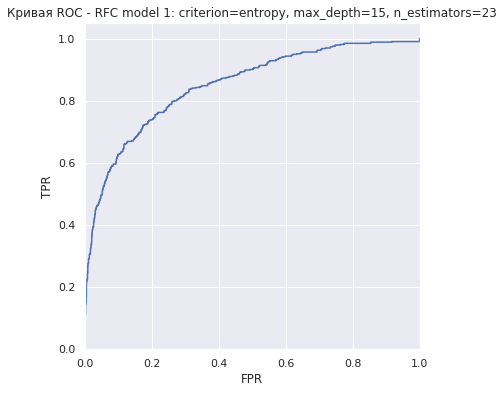

auc_roc = 0.8499036883783977


In [25]:
probabilities = model_f1.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RFC model 1: criterion=entropy, max_depth=15, n_estimators=23')
plt.show()
print('auc_roc =', auc_roc)

In [26]:
def main_param(target, predictions):
    '''
    Функция для вывода основных метрик
    '''
    from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
    print('confusion_matrix\n',confusion_matrix(target, predictions))
    print('recall_score', recall_score(target, predictions))
    print('precision_score', precision_score(target, predictions))
    print('f1_score', f1_score(target, predictions))

In [27]:
predictions = model_f1.predict(X_test_scaled)
print('recall_score', round(recall_score(Y_test, predictions),2))
print('precision_score', round(precision_score(Y_test, predictions),2))
print('f1_score', round(f1_score(Y_test, predictions),2))

result=pd.DataFrame(columns = ['type','criterion', 'max_depth', 'max_features', 'n_estimator', 'recall', 'precision', 'f1'])
result.loc[1] = ['model 1','entropy',15,'auto', 23,round(recall_score(Y_test, predictions),2),round(precision_score(Y_test, predictions),2),round(f1_score(Y_test, predictions),2)]
result

recall_score 0.45
precision_score 0.79
f1_score 0.57


,type,criterion,max_depth,max_features,n_estimator,recall,precision,f1
1,model 1,entropy,15,auto,23,0.45,0.79,0.57


Для модели случайного леса с оптимальными параметрами найденными при наилучшей f1 мере вычисленны следующие метрики:
Recall = 0.45 - эта величина находится между 0 и 1, т.е. средний показатель, но может быть лучше.
Precision = 0.79 - данная величина близка к 1, что оптимально
f1 = 0.57 - агрегирующая мера для данной модели максимальна, т.к. поиск гиперпараметров модели был на основании наилучше f1.

Confusion matrix, without normalization
[[1901   64]
 [ 294  241]]


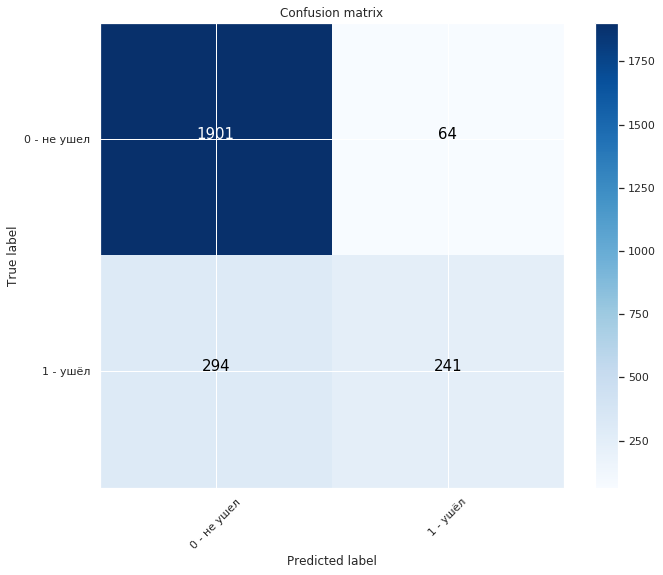

In [28]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

plt.figure(figsize=(10, 8))

cnf_matrix = confusion_matrix(Y_test, predictions);
plot_confusion_matrix(cnf_matrix, classes=['0 - не ушел', '1 - ушёл'],title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

TN - истино-отрицательные ответы = 1901, т.е правильно определённые отрицательные ответы, означающие, что клиент остался;
FN - ложно-отрицательные ответы  = 394, показывает, что клиент остался, не смотря на то, что он ушёл, т.е. ошибка;
TP - истино-положительные ответы = 226, значит, что клиент ушёл;
FP - ложно-положительные ответы  = 61, ошибка, показывает, что клиент ушел, а он оставлся.

F1 мера получилась ниже, чем у более ранней модели, что и стоило ожидать. Теперь рассмотрим модель обученую без гиперпараметров.

In [29]:
model_simple = RandomForestClassifier(random_state=12345)
model_simple.fit(X_train_scaled, Y_train)
predictions = model_simple.predict(X_test_scaled)
main_param(Y_test, predictions)

confusion_matrix
 [[1888   77]
 [ 316  219]]
recall_score 0.4093457943925234
precision_score 0.7398648648648649
f1_score 0.5270758122743683


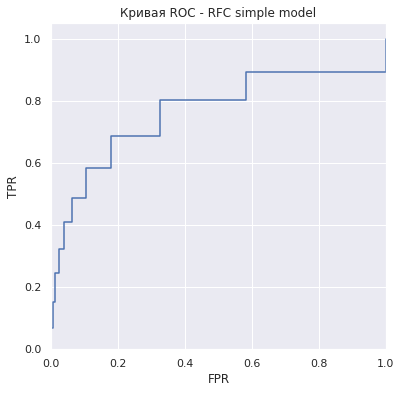

auc_roc = 0.8125109985493805


In [30]:
probabilities = model_simple.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RFC simple model')
plt.show()
print('auc_roc =', auc_roc)

In [31]:
model_simple.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [32]:
result.loc[2] = ['model 2: simple model without params','gini',None,'auto', 10,0.49,0.74,0.53]
result

,type,criterion,max_depth,max_features,n_estimator,recall,precision,f1
1,model 1,entropy,15,auto,23,0.45,0.79,0.57
2,model 2: simple model without params,gini,None,auto,10,0.49,0.74,0.53


## Вывод
Даже без установки гиперпараметров модель показывает сравнимое значение с моделью, по которой был произведен поиск оптимальных параметров с помощью класса GridSearchCV, но не одинаковое, утановка гиперпараметров улучшает качество модели. Возможно поможет устранение дисбаланса классов, а он есть в соотношении нулей и едиц 4:1 соотвественно.

# 3. Борьба с дисбалансом

Воспользуемся параметром class_weight, рассмотрим его влияние:

In [33]:
model_simple = RandomForestClassifier(class_weight='balanced', random_state=12345)
model_simple.fit(X_train_scaled,Y_train)
predictions = model_simple.predict(X_test_scaled)
main_param(Y_test, predictions)

confusion_matrix
 [[1895   70]
 [ 314  221]]
recall_score 0.4130841121495327
precision_score 0.7594501718213058
f1_score 0.5351089588377723


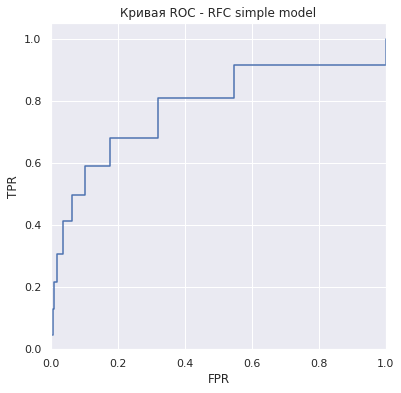

auc_roc = 0.8267004351858458


In [34]:
probabilities = model_simple.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RFC simple model')
plt.show()
print('auc_roc =', auc_roc)

In [35]:
result['class_weight'] = False
result.loc[3] = ['model 2: simple model without params','gini',None,'auto', 10, 0.41, 0.76, 0.53, True]
result

,type,criterion,max_depth,max_features,n_estimator,recall,precision,f1,class_weight
1,model 1,entropy,15,auto,23,0.45,0.79,0.57,False
2,model 2: simple model without params,gini,None,auto,10,0.49,0.74,0.53,False
3,model 2: simple model without params,gini,None,auto,10,0.41,0.76,0.53,True


Установка параметра модели по взвешиванию не привела к существенному улучшению показателей, воспользуемся уменьшенем и увеличением классов.

### Upsampling

Преобразование проходит в несколько этапов:
* Разделить обучающую выборку на объекты по классам;
* Определить тот класс, который содержит меньше объектов. Назовём его меньшим классом;
* Скопировать несколько раз объекты меньшего класса;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные.

In [36]:
repeat = int(round(Y_train[Y_train==0].count()/Y_train[Y_train==1].count(),0))
repeat

4

In [37]:
print(Y_train.value_counts())
Y_train = Y_train.astype('uint8').reset_index(drop=True)
Y_train

0    5998
1    1502
Name: exited, dtype: int64


0       0
1       0
2       0
3       0
4       0
       ..
7495    0
7496    0
7497    0
7498    0
7499    0
Name: exited, Length: 7500, dtype: uint8

In [38]:
search_none(X_train_scaled)
search_nan(X_train_scaled)
X_train_scaled

None пропусков нет в таблице




,credit_score,age,tenure,balance,estimated_salary,gender_Male,geography_Germany,geography_Spain,has_cr_card,is_active_member,num_of_products
0,0.442805,-0.841274,1.426885,-1.224577,-1.269750,0,0,0,1,1,2
1,-0.310897,-0.270730,0.784858,0.641783,0.960396,0,0,1,1,1,1
2,-0.259274,-0.556002,1.105871,-1.224577,0.661864,1,0,0,1,0,2
3,1.217157,1.155631,1.426885,1.290462,-1.039476,1,0,0,1,0,2
4,0.690598,-1.221637,-1.462240,1.142121,-0.851729,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.054275,-0.746183,-0.178184,-1.224577,-1.291837,1,0,0,0,1,2
7496,-1.425964,-0.936365,1.747899,-1.224577,-1.294782,1,0,0,0,1,2
7497,0.040142,0.585087,-1.462240,-0.304909,-0.916678,0,0,0,0,1,1
7498,0.164039,-1.411819,-0.178184,-1.224577,-1.142032,0,0,0,0,1,2


In [39]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
credit_score         7500 non-null float64
age                  7500 non-null float64
tenure               7500 non-null float64
balance              7500 non-null float64
estimated_salary     7500 non-null float64
gender_Male          7500 non-null uint8
geography_Germany    7500 non-null uint8
geography_Spain      7500 non-null uint8
has_cr_card          7500 non-null int64
is_active_member     7500 non-null int64
num_of_products      7500 non-null int64
dtypes: float64(5), int64(3), uint8(3)
memory usage: 490.8 KB


In [40]:
features_zeros = X_train_scaled[Y_train == 0]
features_ones = X_train_scaled[Y_train == 1]
target_zeros = X_train_scaled[Y_train == 0]
target_ones = X_train_scaled[Y_train == 1]
target_ones

,credit_score,age,tenure,balance,estimated_salary,gender_Male,geography_Germany,geography_Spain,has_cr_card,is_active_member,num_of_products
7,-0.589664,1.631085,-1.462240,-1.224577,-1.282642,0,0,0,1,0,1
21,-0.259274,1.250722,-1.462240,-1.224577,-1.179716,0,0,0,1,0,2
26,0.277610,0.394906,-1.141226,0.912877,0.186138,1,0,0,1,0,1
29,0.938391,-1.031456,-0.820212,1.853403,0.141550,0,0,0,1,0,1
55,0.711247,0.585087,-1.141226,0.425911,-1.119562,0,0,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
7472,-1.157522,-0.080548,1.105871,0.466873,-0.341293,0,1,0,0,0,1
7479,0.370533,2.106539,0.784858,0.067461,0.537200,0,0,0,1,0,1
7486,-2.768174,0.870359,1.105871,0.312423,0.647971,0,0,1,0,0,1
7488,-0.021806,-0.175639,1.105871,0.616092,0.110343,0,1,0,1,1,1


In [41]:
def upsample(X_train_scaled, y, repeat):
    features_zeros = X_train_scaled[Y_train == 0]
    features_ones = X_train_scaled[Y_train == 1]
    target_zeros = Y_train[Y_train == 0]
    target_ones = Y_train[Y_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(X_train_scaled, Y_train, 4)

model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled,target_upsampled)

predicted_valid = model.predict(X_test_scaled)

repeat = (target_upsampled[target_upsampled==0].count()/target_upsampled[target_upsampled==1].count())
print('соотношение классов:', repeat)

print("F1:", round(f1_score(Y_test, predicted_valid),2))

соотношение классов: 0.998335552596538
F1: 0.55


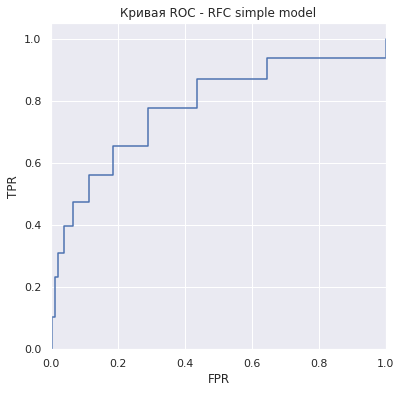

auc_roc = 0.8193427029083733


In [42]:
probabilities = model.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RFC simple model')
plt.show()
print('auc_roc =', auc_roc)

## Комментарий наставника
<span style="color:green">Замечательно, upsampling проведён верно.</span>

In [43]:
result['upsample'] = False
result.loc[4]=['model 2: simple model without params', 'gini',None,'auto', 10, 0.52, 0.64, 0.58, False, True]
result

,type,criterion,max_depth,max_features,n_estimator,recall,precision,f1,class_weight,upsample
1,model 1,entropy,15,auto,23,0.45,0.79,0.57,False,False
2,model 2: simple model without params,gini,None,auto,10,0.49,0.74,0.53,False,False
3,model 2: simple model without params,gini,None,auto,10,0.41,0.76,0.53,True,False
4,model 2: simple model without params,gini,None,auto,10,0.52,0.64,0.58,False,True


confusion_matrix
 [[1838  127]
 [ 282  253]]
recall_score 0.47289719626168225
precision_score 0.6657894736842105
f1_score 0.5530054644808743
Confusion matrix, without normalization
[[1901   64]
 [ 294  241]]


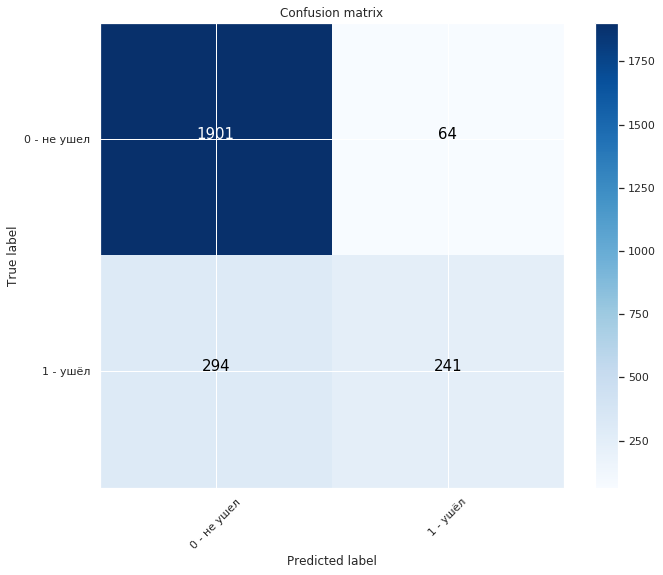

In [44]:
main_param(Y_test,model.predict(X_test_scaled))

#cnf_matrix = confusion_matrix(Y_test, model.predict(X_test_scaled))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0 - не ушел', '1 - ушёл'],title='Confusion matrix')
plt.show()

### Downsample

Преобразование проходит в несколько этапов:
* Разделить обучающую выборку на отрицательные и положительные объекты;
* Случайным образом отбросить часть из отрицательных объектов;
* С учётом полученных данных создать новую обучающую выборку;
* Перемешать данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [45]:
fraction = round((Y_train[Y_train==1].count()/Y_train[target==0].count()),2)
fraction

0.25

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

best_f1 = {}
for i in np.arange(0.100,0.890,0.001):
    features_downsampled, target_downsampled = downsample(X_train_scaled, Y_train, i)

    model = RandomForestClassifier(random_state = 12345)
    model.fit(features_downsampled,target_downsampled)
    predicted_valid = model.predict(X_test_scaled)
    best_f1[i] = f1_score(Y_test, predicted_valid)


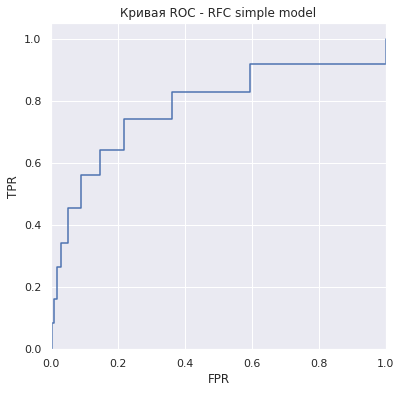

auc_roc = 0.823255095003686


In [47]:
probabilities = model.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC - RFC simple model')
plt.show()
print('auc_roc =', auc_roc)

In [48]:
max_key = max(best_f1, key=best_f1.get)
max_key

0.42700000000000027

In [49]:
result['downsample'] = False
result.loc[5]=['model 2: simple model without params', 'gini',None,'auto', 10, 0.62, 0.62, 0.62, False, False, True]
result

,type,criterion,max_depth,max_features,n_estimator,recall,precision,f1,class_weight,upsample,downsample
1,model 1,entropy,15,auto,23,0.45,0.79,0.57,False,False,False
2,model 2: simple model without params,gini,None,auto,10,0.49,0.74,0.53,False,False,False
3,model 2: simple model without params,gini,None,auto,10,0.41,0.76,0.53,True,False,False
4,model 2: simple model without params,gini,None,auto,10,0.52,0.64,0.58,False,True,False
5,model 2: simple model without params,gini,None,auto,10,0.62,0.62,0.62,False,False,True


confusion_matrix
 [[1767  198]
 [ 205  330]]
recall_score 0.616822429906542
precision_score 0.625
f1_score 0.6208842897460018
Confusion matrix, without normalization
[[1767  198]
 [ 205  330]]


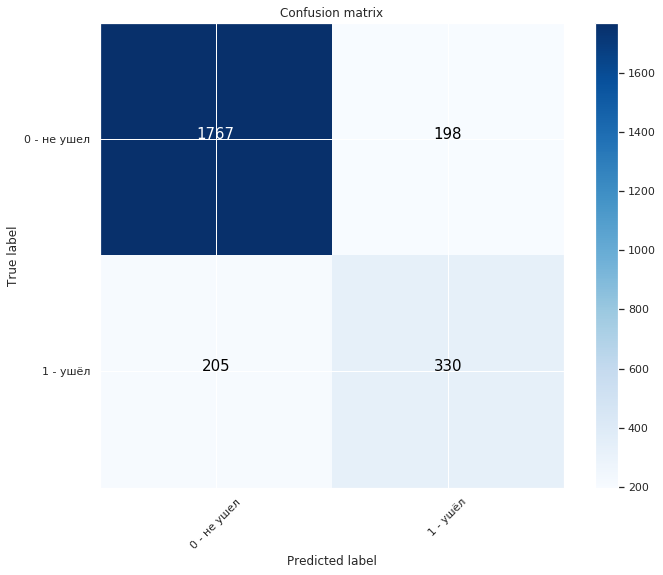

In [50]:
features_downsampled, target_downsampled = downsample(X_train_scaled, Y_train, max_key)
model = RandomForestClassifier(random_state = 12345)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(X_test_scaled)
#f1_score(target_scaled_valid, predicted_valid)

main_param(Y_test, predicted_valid)
cnf_matrix = confusion_matrix(Y_test, predicted_valid)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0 - не ушел', '1 - ушёл'],title='Confusion matrix')
plt.show()

### Вывод
Максимальное значение f1 получено при downsample = 0.62. При исаользовании метода Upsample было получено значение 0.55. Да, оба метода дают прирост по метрике f1, но наибольший прирост был при downsample. Следующим шагом должен быть поиск оптимальных гиперпараметров.

### Подбор параметров модели по обновленому сету данных

In [51]:
%%time
rfc = RandomForestClassifier(class_weight='balanced', random_state=12345)
param_grid = {'n_estimators': range(1, 50, 2)\
              ,'max_features': ['auto']\
              ,'max_depth' : range(1, 50, 2)\
              ,'criterion' : ['gini', 'entropy']\
             }
grid_cv = GridSearchCV(rfc, param_grid, scoring='f1', cv=5)

grid_cv.fit(features_downsampled,target_downsampled)
print('\nbest_params_ \n', grid_cv.best_params_)
print('\nbest_score \n', grid_cv.best_score_)


best_params_ 
 {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 43}

best_score 
 0.7107160161406747
CPU times: user 19min 15s, sys: 4.37 s, total: 19min 19s
Wall time: 19min 22s


### Вывод
Параметры найдены, требуется протестировать данную модель

В отличии от предыдущей версии, вследствии правильного масштабирования результат модели изменился и мера f1 дала результат 0.71, что на десятую часть лучше предыдущих результатов. Количество деревьев возросло до 43, а глубина уменьшилась до 7, критерий - gini. Такаим образом, данная модель показала наилучший результат. Влияние дисбаланса классов, очень сильно сказывалось на качестве модели.

# 4. Тестирование модели

### Проверка

По обновленному data set, по которому была произведена балансировка и получены гиперпараметры лучшей модели по метрике f1=0.71 сделаем модель и проверим её

confusion_matrix
 [[1810  155]
 [ 218  317]]
recall_score 0.5925233644859813
precision_score 0.6716101694915254
f1_score 0.6295928500496524
Confusion matrix, without normalization
[[1810  155]
 [ 218  317]]


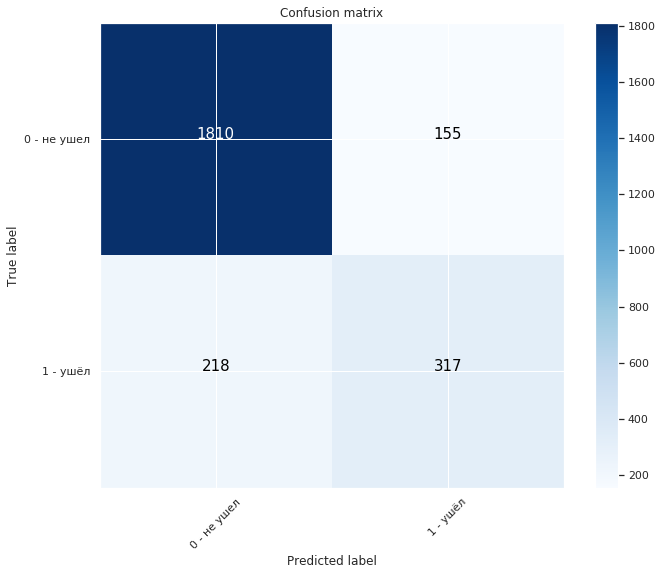

In [52]:
model = RandomForestClassifier(\
                               criterion='gini',\
                               max_depth=7,\
                               max_features='auto',\
                               n_estimators=43,\
                               #class_weight='balanced',\
                               random_state=12345\
                              )
model.fit(features_downsampled,target_downsampled)

predicted_valid = model.predict(X_test_scaled)

main_param(Y_test, predicted_valid)

cnf_matrix = confusion_matrix(Y_test, predicted_valid)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0 - не ушел', '1 - ушёл'],title='Confusion matrix')
plt.show()

На графике отчётливо видно, что предсказательная характеристика улучшилась, но не достигает того же результата, что при кроссвалидации, разница в 10 процентах.

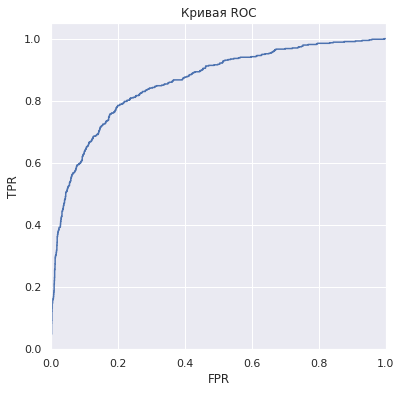

auc_roc = 0.8600494637464032


In [53]:
probabilities = model.predict_proba(X_test_scaled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(Y_test, probabilities_one_valid)
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()
print('auc_roc =', auc_roc)

### Вывод
Метрика auc_roc больше случайной модели, что говорит о её адекватности и правильности. 

# Общий итог
Была расмотрена структура RandomForestClassifier на основе которой были получены модели и наилучшие результаты показала модель найденая с помощью gridSearch('criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 43), но обученная на новом датасете, который был подвергнут downsample, т.е. был получен баланс классов за счет случайного удаления записей. Аналогичная методика балансировки методом upsample не дала значимого прироста по f1 мере. В прошлой версии данного проекта, наилучший результат дала модель юез гиперпараметров.

Изначальный сет данных был преобразован и из него были убраны идентификаторы, числовые данные масштабированы, за исключением булевых признаков. Параметр "class_weight" не дал существенного резульатата модели. Итоговая модель имеет значение меры f1=0.63, что превышает пороговое значение текущего проекта. Метрика AUC-ROC также оказалась выше случайной модели на 0.36, что показывает качество полученной модели. Также стоит заметить, что модель на кроссвалидации получила метрику f1=0.72, а при обучении модели на данных гиперпараметрах метрика f1=0.63.